In [2]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

In [52]:
Xi,y = load_eeg_label_pair()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from scipy.signal import resample

In [54]:
X = torch.from_numpy(resample(Xi.flatten(),86400*100)).reshape(-1,1000)
scaler = RobustScaler()
X = torch.from_numpy(scaler.fit_transform(X.reshape(-1,1)).reshape(-1,100*10)).float()
X_train,X_dev,y_train,y_dev = train_test_split(X,y,test_size=.5,stratify=y,shuffle=True,random_state=0)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=32,shuffle=True)
devloader = DataLoader(TensorDataset(X_dev,y_dev),batch_size=32,shuffle=True)

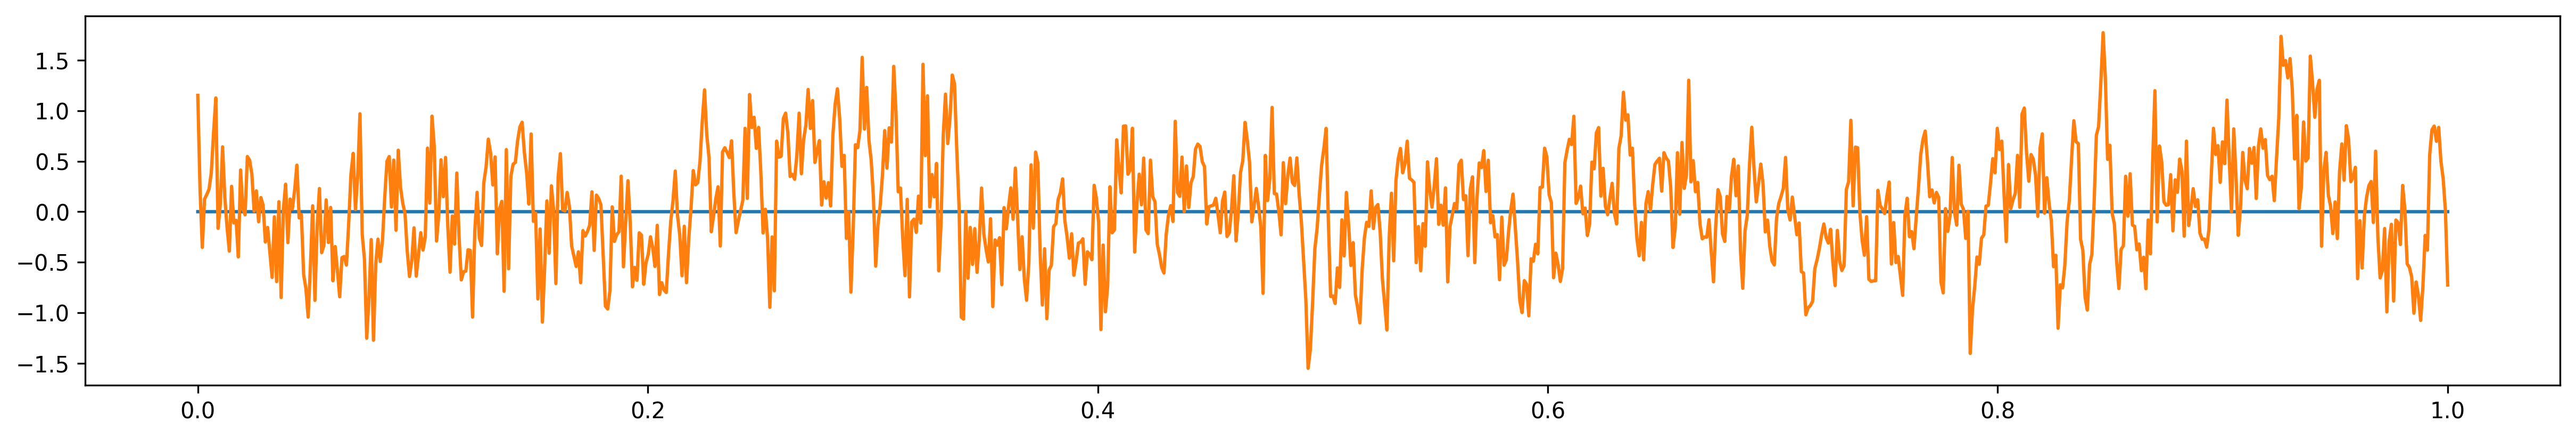

In [55]:
plt.figure(figsize=(20,3),dpi=300)
plt.plot(torch.linspace(0,1,5000),Xi[0])
plt.plot(torch.linspace(0,1,1000),X[0])

In [57]:
class MODEL(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        n_feature_maps = 4
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=n_feature_maps,kernel_size=3,stride=1,bias=False,padding='same'),
            nn.LayerNorm(normalized_shape=(n_feature_maps,1000)),
            nn.ReLU(),
            nn.Conv1d(in_channels=n_feature_maps,out_channels=n_feature_maps,kernel_size=3,stride=1,bias=False,padding='same'),
            nn.LayerNorm(normalized_shape=(n_feature_maps,1000)),
            nn.ReLU(),
            nn.Conv1d(in_channels=n_feature_maps,out_channels=n_feature_maps,kernel_size=3,stride=1,bias=False,padding='same'),
            nn.LayerNorm(normalized_shape=(n_feature_maps,1000)),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=1000)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=n_feature_maps,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=3)
        )
    def forward(self,x):
        x = x.view(-1,1,1000)
        x = self.encoder(x)
        x = self.classifier(x.squeeze(2))
        return x
model = MODEL().to('mps')
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

Params:  24367


100%|██████████| 135/135 [00:01<00:00, 112.11it/s]


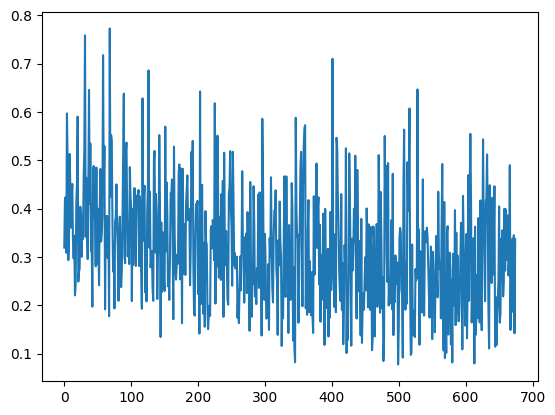

In [62]:
lossi = []
for epoch in range(5):
    for Xi,yi in tqdm(trainloader):
        logits = model(Xi.to('mps'))
        loss = criterion(logits,yi.to('mps'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
plt.plot(lossi)

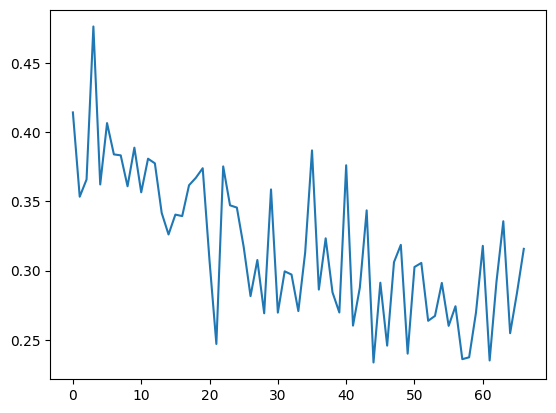

In [63]:
plt.plot(torch.tensor(lossi[:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1))

In [66]:
loss,report,y_true,y_pred,y_logits = evaluate(devloader,model,criterion,'mps')
print(loss,report)

100%|██████████| 135/135 [00:00<00:00, 284.79it/s]

0.31471849553011083 {'precision': 0.6011913533410534, 'recall': 0.6292086749344886, 'f1': 0.6145366153047371}



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


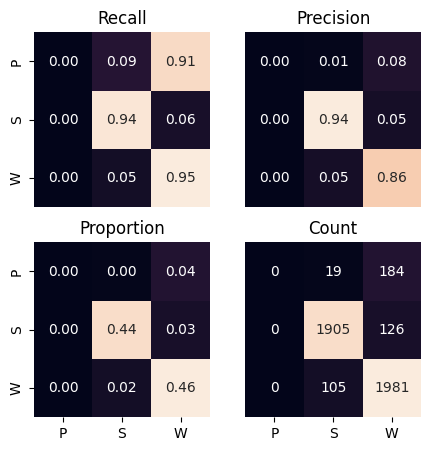

In [67]:
cm_grid(y_true,y_pred)